In [5]:
from mel2spec_model import Mel2Spec
from mel2spec_data import ToData
import config
import torch
from torch.utils import data as DataUtil
import h5py
import pytorch_lightning as pl

In [6]:
uselen = -1
class OriginalData(DataUtil.Dataset):
    def __init__(self) -> None:
        super().__init__()

        with h5py.File(ToData.filepath,'r',swmr=True) as f:
            self.data = torch.from_numpy(f[ToData.data_key][:uselen])
            self.ans = torch.from_numpy(f[ToData.answer_key][:uselen])
        print(self.data.shape,self.ans.shape)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        return self.data[index],self.ans[index]

data_set = OriginalData()

torch.Size([20, 128, 64]) torch.Size([20, 64, 321, 2])


In [7]:
model = Mel2Spec()
batch_size = 16
EPOCHS = 1000
data_loader = DataUtil.DataLoader(data_set,batch_size,shuffle=True,num_workers=0,pin_memory=False)

In [8]:
trainer = pl.Trainer(gpus=1,num_nodes=1,precision=16,max_epochs=EPOCHS)
trainer.fit(model,data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | criterion    | MSELoss    | 0     
1 | channel_conv | ConvNorm1d | 124 K 
2 | layers       | Sequential | 38.1 K
3 | out_conv     | Conv2d     | 1.2 K 
--------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=0.00943, v_num=11]


In [9]:
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
name = f'params/Mel2Spec_{now}.params'
torch.save(model.state_dict(),name)
print('saved')

saved


In [24]:
viewlen = 10
with torch.no_grad():
    model.eval()
    model.cuda()
    model.half()
    data = data_set.data[:viewlen].cuda()
    ans = data_set.ans[:viewlen].float()
    out = model(data).cpu().detach().float()
    ans_sound = torch.view_as_complex(ans)
    ans_sound = torch.fft.irfft(ans_sound).float()
    out_sound = torch.view_as_complex(out.contiguous())
    out_sound = torch.fft.irfft(out_sound).float()
    

In [1]:
import matplotlib.pyplot as plt
for i in range(len(ans)):
    fig,ax = plt.subplots(1,2,figsize=(7,3))
    ax[0].plot(ans_sound[i].reshape(-1))
    ax[1].plot(out_sound[i].reshape(-1))

NameError: name 'ans' is not defined

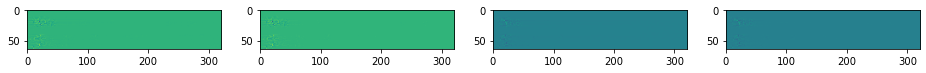

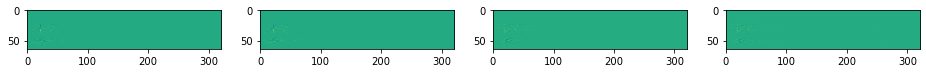

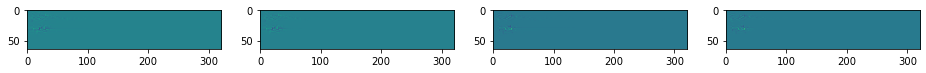

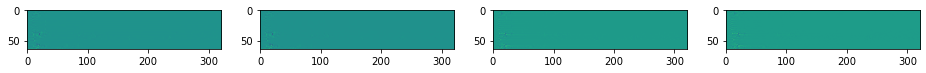

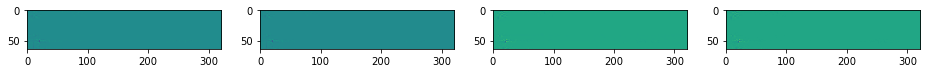

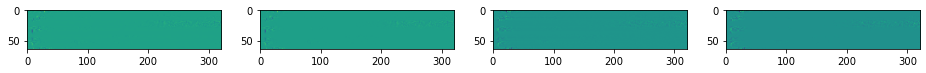

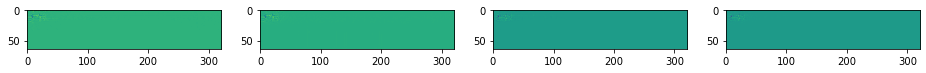

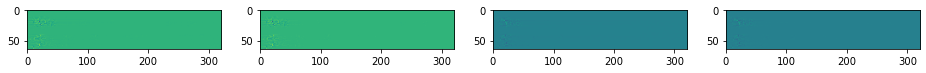

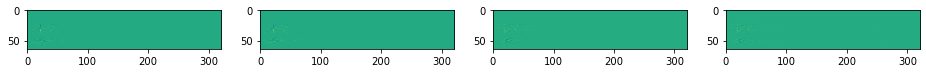

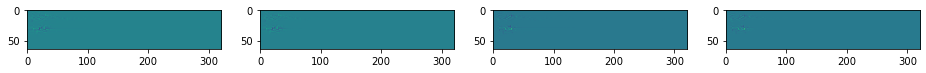

In [19]:
import matplotlib.pyplot as plt
for i in range(len(ans)):
    fig,ax = plt.subplots(1,4,figsize=(16,10))
    ax[0].imshow(ans[i,:,:,0])
    ax[1].imshow(out[i,:,:,0])
    ax[2].imshow(ans[i,:,:,1])
    ax[3].imshow(out[i,:,:,1])
    plt.show()